In [1]:
import pandas as pd

In [2]:
dataset=pd.read_csv("cleaned_data.csv")

In [4]:
dataset.head()

,Unnamed: 0,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),...,STDs:HIV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,...,0.0,0,1,0,1,0,0,0,0,0
4,4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,...,0.0,0,0,0,0,0,0,0,0,0


In [7]:
dataset=dataset.drop(columns='Unnamed: 0')

In [11]:
dataset.shape

(835, 26)

In [12]:
feature_df=dataset.drop(columns='Biopsy')
target_df=dataset['Biopsy']

In [14]:
target_df.value_counts()

Biopsy
0    781
1     54
Name: count, dtype: int64

In [15]:
#handling class imbalance
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [16]:
X = feature_df
y = target_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
smote=SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

In [18]:
pd.Series(y_train_oversampled).value_counts()

Biopsy
0    624
1    624
Name: count, dtype: int64

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)


In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

In [47]:
myclf1 = LogisticRegression(random_state=8)
myclf2 = GaussianNB()
myclf3 = DecisionTreeClassifier(max_depth=100, min_samples_split=5, random_state=8)
myclf4 = KNeighborsClassifier(n_neighbors=6, weights='uniform')
myclf5 = SVC(probability=True,random_state=8)

mylr = XGBClassifier(random_state=8)

In [48]:
stackingclf = StackingClassifier(
    estimators=[('log_reg', myclf1), ('naive_bayes', myclf2), 
                ('decision_tree', myclf3), ('knn', myclf4), 
                ('svm', myclf5)],
    final_estimator=mylr,cv=5)

In [49]:
stackingclf.fit(X_train_scaled, y_train_oversampled)

StackingClassifier(cv=5,
                   estimators=[('log_reg', LogisticRegression(random_state=8)),
                               ('naive_bayes', GaussianNB()),
                               ('decision_tree',
                                DecisionTreeClassifier(max_depth=100,
                                                       min_samples_split=5,
                                                       random_state=8)),
                               ('knn', KNeighborsClassifier(n_neighbors=6)),
                               ('svm', SVC(probability=True, random_state=8))],
                   final_estimator=XGBClassifier(base_score=None, booster=Non...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=8, ...))

In [43]:
y_pred = stackingclf.predict(X_test_scaled)

In [44]:

pred_score=accuracy_score(y_test, y_pred)
pred_score

0.9640718562874252

In [68]:
scores = cross_val_score(stackingclf, X_train_scaled, y_train_oversampled, cv=5)  
scores.mean()

0.9535389558232932

In [63]:
#tree based feature selection
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=18, random_state=8)
clf.fit(X_train_scaled, y_train_oversampled)
y_pred = clf.predict(X_test_scaled)

importances = clf.feature_importances_

threshold = 0.03
tree_selected_features = feature_df.columns[importances > threshold]

In [64]:
tree_selected_features

Index(['Age', 'First sexual intercourse', 'Num of pregnancies',
       'Hormonal Contraceptives (years)', 'Schiller'],
      dtype='object')

In [66]:
#recursive feature elimination based feature selection

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, max_depth=10)

from sklearn.feature_selection import RFE

n_features_to_select = 1
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train_scaled, y_train_oversampled)

from operator import itemgetter

features = X_train.columns.to_list()


In [67]:
rfe_selected_features = [y for x, y in sorted(zip(rfe.ranking_, features), key=itemgetter(0))][:5]

print(rfe_selected_features)

['Schiller', 'First sexual intercourse', 'Num of pregnancies', 'Age', 'Number of sexual partners']


In [72]:
X_test_scaled

array([[-0.88289085,  0.48326178, -0.8043851 , ..., -0.37379945,
        -0.81486195, -0.24376782],
       [-0.99934062, -0.3329195 , -0.8043851 , ..., -0.37379945,
        -0.81486195, -0.24376782],
       [-0.76644107, -1.14910079,  1.23256701, ..., -0.37379945,
        -0.81486195, -0.24376782],
       ...,
       [ 1.32965489,  2.11562435,  0.41778617, ..., -0.37379945,
        -0.81486195, -0.24376782],
       [-0.53354152, -0.3329195 , -0.39699468, ..., -0.37379945,
        -0.81486195, -0.24376782],
       [-0.88289085,  0.48326178,  0.01039574, ..., -0.37379945,
        -0.81486195, -0.24376782]])

In [75]:
X_train.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:HIV',
       'STDs: Number of diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx',
       'Hinselmann', 'Schiller', 'Citology'],
      dtype='object')

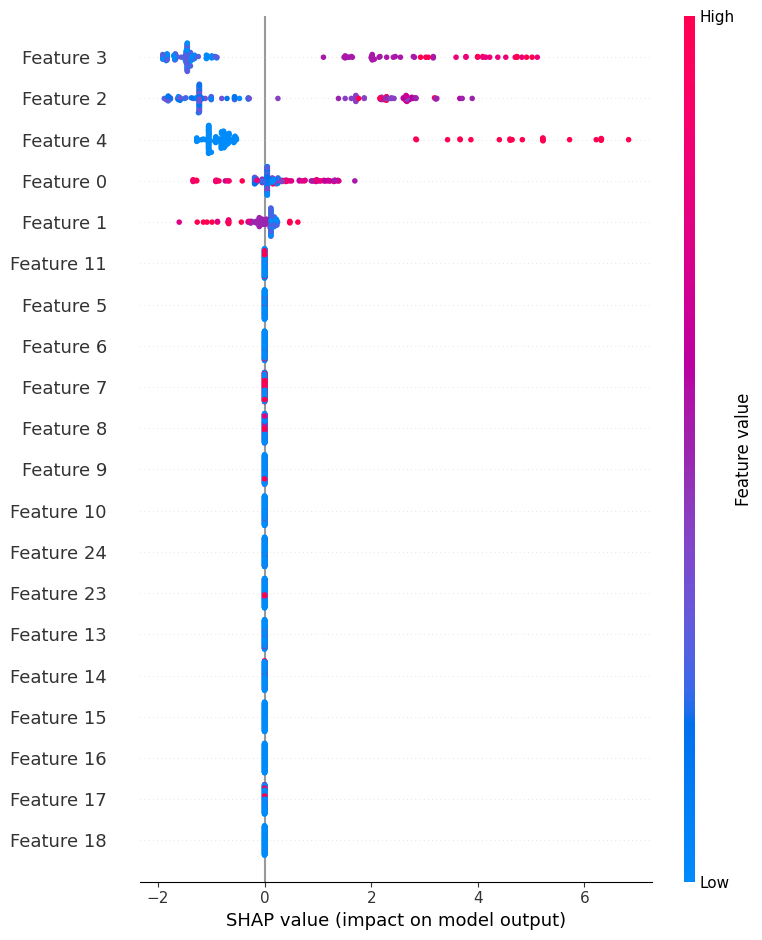

In [74]:
#shap
import shap

explainer = shap.Explainer(stackingclf.final_estimator_, X_train_scaled)

shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


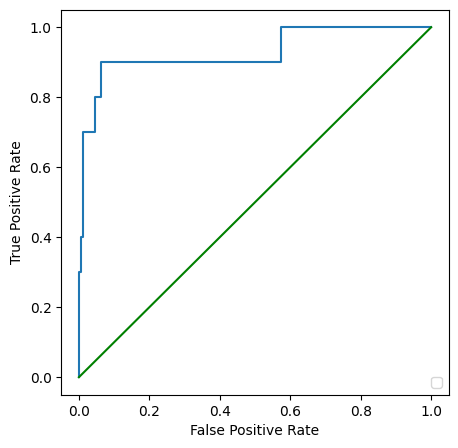

In [78]:
from matplotlib import pyplot as plt

y_proba = stackingclf.predict_proba(X_test_scaled)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
plot_auc_roc_curve(y_test, y_proba[:, 1])